In [294]:
np.array([0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1])

print(x[18])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (111768918.py, line 1)

In [117]:
import gymnasium as gym
import numpy as np
from typing import List, Optional
from models.envs.env import BaseEnvironment

class SchoolMealSelectionDiscrete(BaseEnvironment):
    """
    A custom Gym environment for selecting school meals that meet certain nutritional and environmental criteria.
    The environment allows actions to adjust the quantity of ingredients and calculates rewards based on multiple metrics,
    such as nutrient values, environmental impact, cost, and consumption patterns.
    """
    metadata = {"render_modes": ["human"], 'render_fps': 1}

    def __init__(self, ingredient_df, max_ingredients: int = 6, action_scaling_factor: int = 10, render_mode: str = None, 
                 verbose: int = 0, seed: int = None, reward_calculator_type: str = 'sparse', 
                 initialization_strategy: str = 'zero', max_episode_steps: int = 100):
        super().__init__(ingredient_df, max_ingredients, action_scaling_factor, render_mode, verbose, seed, reward_calculator_type, initialization_strategy, max_episode_steps)
        
        # Define the action space: 0 (set to zero), 1 (stay the same), 2 (decrease), 3 (increase)
        self.initialize_action_space()
        
        self.invalid_actions: List[int] = []
        self.n_invalid_actions = 0  # You can set this dynamically as needed
        self.possible_actions = np.arange(4 * self.n_ingredients)

    def initialize_action_space(self) -> None:
        self.action_space = gym.spaces.MultiDiscrete([4] * self.n_ingredients)
        
    def update_selection(self, action: np.ndarray) -> None:
        """
        Update the current selection of ingredients based on the action.
        """
        for i in range(len(action)):
            if action[i] == 0:
                self.current_selection[i] = 0
            elif action[i] == 1:
                continue  # No change
            elif action[i] == 2:
                self.current_selection[i] = max(0, self.current_selection[i] - self.action_scaling_factor)
            elif action[i] == 3:
                self.current_selection[i] += self.action_scaling_factor

        # Ensure that the number of selected ingredients does not exceed the maximum allowed
        num_selected_ingredients = np.sum(self.current_selection > 0)
        if num_selected_ingredients > self.max_ingredients:
            excess_indices = np.argsort(-self.current_selection)
            self.current_selection[excess_indices[self.max_ingredients:]] = 0
            print("current_selection was cut")

    def validate_action_shape(self, action: np.ndarray) -> None:
        """
        Validate the shape of the action array.
        """
        if self.verbose > 1:
            if not isinstance(action, np.ndarray) or action.shape != (self.n_ingredients,):
                raise ValueError(f"Expected action to be an np.ndarray of shape {(self.n_ingredients,)}, but got {type(action)} with shape {action.shape}")
            if action.shape != self.action_space.shape:
                raise ValueError(f"Action shape {action.shape} is not equal to action space shape {self.action_space.shape}")

    def _choose_invalid_actions(self) -> None:
        """
        Randomly choose invalid actions that are not the current state.
        """
        self.state = self.action_space.sample()
        converted_state: List[int] = []
        running_total = 0
        for i in range(len(self.action_space.nvec)):
            converted_state.append(running_total + self.state[i])
            running_total += self.action_space.nvec[i]

        # Randomly choose invalid actions that are not the current state
        potential_invalid_actions = [i for i in self.possible_actions if i not in converted_state]
        self.invalid_actions = np.random.choice(potential_invalid_actions, self.n_invalid_actions, replace=False).tolist()

    def action_masks(self) -> List[bool]:
        """
        Generate action masks indicating valid actions.
        """
        self._choose_invalid_actions()
        return [action not in self.invalid_actions for action in self.possible_actions]

# Example usage
from utils.process_data import get_data
ingredient_df = get_data()  # Replace with your actual dataframe
n_ingredients = 26
max_ingredients = 5
env = SchoolMealSelectionDiscrete(ingredient_df, max_ingredients)

# Reset the environment
observation = env.reset()
print("Initial observation:", observation)

# Get the action mask
action_mask = env.action_masks()
print("Action mask:", action_mask)
print("Length of Action mask:", len(action_mask))
# Take a step with a sample action
action = env.action_space.sample()
print("Action:", action)

observation, reward, done, truncated, info = env.step(action)
print("Observation after step:", observation)


Successfully read 27 lines from the file. Loaded 26 ingredients.
Initial observation: ({'current_selection_value': array([0., 0., 0., 0., 0.]), 'current_selection_index': array([-1., -1., -1., -1., -1.]), 'time_feature': array([1.]), 'nutrients': array([0., 0., 0., 0., 0., 0., 0., 0.]), 'groups': array([0., 0., 0., 0., 0., 0., 0.]), 'environment_counts': array([0., 0., 0., 0.]), 'cost': array([0.]), 'co2_g': array([0.]), 'consumption': array([0., 0.])}, {'nutrient_averages': {'calories': 0.0, 'fat': 0.0, 'saturates': 0.0, 'carbs': 0.0, 'sugar': 0.0, 'fibre': 0.0, 'protein': 0.0, 'salt': 0.0}, 'ingredient_group_count': {'fruit': 0.0, 'veg': 0.0, 'protein': 0.0, 'carbs': 0.0, 'dairy': 0.0, 'bread': 0.0, 'confectionary': 0.0}, 'ingredient_environment_count': {'animal_welfare': 0, 'rainforest': 0, 'water': 0, 'co2_rating': 0}, 'consumption_average': {'average_mean_consumption': 0.0, 'average_cv_ingredients': 0.0}, 'cost': {'cost': 0.0}, 'co2_g': {'co2_g': 0.0}, 'reward': {'nutrient_reward'

In [161]:
x = np.ones(10 + 4, dtype=np.int8)
x[-4:] = -1

print(x)

[ 1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1]


In [290]:
import gymnasium as gym
import numpy as np
n_ingredients = 2

multi_discrete_space = gym.spaces.MultiDiscrete([4] * n_ingredients)
multi_discrete_space1 = gym.spaces.MultiDiscrete([4, n_ingredients])

# Print the MultiDiscrete space to see its definition
print(multi_discrete_space)
print(multi_discrete_space1)

# Sample from the MultiDiscrete space multiple times
for _ in range(5):
    sample = multi_discrete_space.sample()
    # print(sample)
    sample = multi_discrete_space1.sample()
    print(sample[1])

MultiDiscrete([4 4])
MultiDiscrete([4 2])
0
1
0
1
0


In [1]:
import numpy as np
from utils.process_data import get_data
import random

# Load data
ingredient_df = get_data()
n_ingredients = len(ingredient_df)

# Extract group columns
group_a_veg = ingredient_df['Group A veg'].values.astype(np.float32)
group_a_fruit = ingredient_df['Group A fruit'].values.astype(np.float32)
group_bc = ingredient_df['Group BC'].values.astype(np.float32)
group_d = ingredient_df['Group D'].values.astype(np.float32)
group_e = ingredient_df['Group E'].values.astype(np.float32)
bread = ingredient_df['Bread'].values.astype(np.float32)
confectionary = ingredient_df['Confectionary'].values.astype(np.float32)

# Group info dictionary
group_info = {
    'fruit': {'indexes': np.nonzero(group_a_fruit)[0], 'probability': 0.8},
    'veg': {'indexes': np.nonzero(group_a_veg)[0], 'probability': 0.8},
    'protein': {'indexes': np.nonzero(group_bc)[0], 'probability': 0.8},
    'carbs': {'indexes': np.nonzero(group_d)[0], 'probability': 0.8},
    'dairy': {'indexes': np.nonzero(group_e)[0], 'probability': 0.8},
    'bread': {'indexes': np.nonzero(bread)[0], 'probability': 0.8},
    'confectionary': {'indexes': np.nonzero(confectionary)[0], 'probability': 0.01}
}

# Ingredient group count targets
ingredient_group_count_targets = {
    'fruit': 1,
    'veg': 1,
    'protein': 1,
    'carbs': 1,
    'dairy': 1,
    'bread': 1,
    'confectionary': 0
}

# Initialize variables
current_selection = np.zeros(n_ingredients, dtype=np.float32)
selected_indices = []

# Select indices based on targets
for key, value in ingredient_group_count_targets.items():
    if value > 0:
        selected_indices.extend(random.sample(list(group_info[key]['indexes']), value))

selected_dict = {key: [] for key in ingredient_group_count_targets}

for idx in selected_indices:
    for category, info in group_info.items():
        if idx in info['indexes']:
            selected_dict[category].append(idx)
            
current_selection[selected_indices] = 1

# Create action mask
action_mask = np.zeros(n_ingredients * 2, dtype=np.int8)
non_zero_mask = current_selection != 0

# Calculate ingredient group count
ingredient_group_count = {
    'fruit': np.sum(group_a_fruit * non_zero_mask),
    'veg': np.sum(group_a_veg * non_zero_mask),
    'protein': np.sum(group_bc * non_zero_mask),
    'carbs': np.sum(group_d * non_zero_mask),
    'dairy': np.sum(group_e * non_zero_mask),
    'bread': np.sum(bread * non_zero_mask),
    'confectionary': np.sum(confectionary * non_zero_mask)
}

# Update action mask for selected indices only
for key, value in ingredient_group_count.items():
    target = ingredient_group_count_targets[key]
    indexes = group_info[key]['indexes']
    selected = [idx for idx in selected_indices if idx in indexes]
    
    if target == 0:
        for idx in indexes:
            action_mask[idx * 2: idx * 2 + 2] = [0, 0]
        continue
        
    if value == target:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 1]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [0, 0]
    elif value < target:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 1]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [1, 1]
    else:
        for idx in selected:
            action_mask[idx * 2: idx * 2 + 2] = [1, 0]
        for idx in indexes:
            if idx not in selected:
                action_mask[idx * 2: idx * 2 + 2] = [0, 0]

action_mask = np.reshape(action_mask, (n_ingredients, 2))

# Output results
print(action_mask)

mask = {}
i = 0
for l in action_mask:
    mask[i] = l
    i += 1
  
print(mask)  
print(current_selection)
print(ingredient_group_count)
print(selected_dict)
print(group_info['confectionary']['indexes'])


Successfully read 27 lines from the file. Loaded 26 ingredients.
[[0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [1 1]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 0]]
{0: array([0, 0], dtype=int8), 1: array([0, 0], dtype=int8), 2: array([1, 1], dtype=int8), 3: array([0, 0], dtype=int8), 4: array([0, 0], dtype=int8), 5: array([0, 0], dtype=int8), 6: array([0, 0], dtype=int8), 7: array([0, 0], dtype=int8), 8: array([1, 1], dtype=int8), 9: array([0, 0], dtype=int8), 10: array([0, 0], dtype=int8), 11: array([0, 0], dtype=int8), 12: array([0, 0], dtype=int8), 13: array([0, 0], dtype=int8), 14: array([1, 1], dtype=int8), 15: array([0, 0], dtype=int8), 16: array([0, 0], dtype=int8), 17: array([1, 1], dtype=int8), 18: array([0, 0], dtype=int8), 19: array([0, 0], dtype=int8), 20: array([1, 1], dtype=int8), 21: array([0, 0], dtype=int8), 22: array([0, 0], dtype=int8), 23: array([0, 0], dtype=int8), 24: array([1, 1],

In [3]:
from gym.spaces import Box, MultiDiscrete, Dict
from collections import OrderedDict
import numpy as np
import os
from utils.process_data import get_data
from gymnasium.utils.env_checker import check_env
from gymnasium.wrappers import TimeLimit, NormalizeObservation, NormalizeReward
from stable_baselines3.common.monitor import Monitor
from utils.train_utils import setup_environment, get_unique_directory, monitor_memory_usage, plot_reward_distribution, set_seed
reward_dir, reward_prefix = get_unique_directory("saved_models/reward", 'reward_test34', '')

class Args:
    reward_metrics = None
    render_mode = None
    num_envs = 1
    plot_reward_history = False
    max_episode_steps = 1000
    verbose = 2
    action_scaling_factor = 10
    memory_monitor = True
    gamma = 0.99
    max_ingredients = 6
    action_scaling_factor = 10
    reward_save_interval = 1000
    vecnorm_norm_obs = True
    vecnorm_norm_reward = True
    vecnorm_clip_obs = 10
    vecnorm_clip_reward = 10
    vecnorm_epsilon = 1e-8 
    vecnorm_norm_obs_keys = None
    ingredient_df = get_data("small_data.csv")
    seed = 10
    env_name = 'SchoolMealSelection-v0'
    perfect_initialize = 'perfect'
    vecnorm_norm_obs_keys = ['current_selection_value', 'time_left', 'cost', 'consumption', 'co2g']
args = Args()

num_episodes = 1000

reward_save_path = os.path.abspath(os.path.join(reward_dir, reward_prefix))

env = setup_environment(args, reward_save_path=reward_save_path, eval=False)
    
# Assuming your state and observation space are set up as above
state = OrderedDict([
    ('co2g', np.array([0.00999999], dtype=np.float32)),
    ('consumption', np.array([[0.00999125, 0.00984591]], dtype=np.float32)),
    ('cost', np.array([[0.00884706]], dtype=np.float32)),
    ('current_selection_index', np.array([[0, 2, 7, 13, 15, 25]])),
    ('current_selection_value', np.array([[0.00999906, 0.00999981, 0.00999934, 0.00999984, 0.0099996, 0.00999808]], dtype=np.float32)),
    ('environment_counts', np.array([[2, 3, 1, 2]])),
    ('groups', np.array([[1, 1, 1, 1, 1, 1, 0]])),
    ('nutrients', np.array([[690.27, 21.514, 7.534, 85.008995, 24.738998, 10.741, 35.691, 1.2396]], dtype=np.float32)),
    ('time_left', np.array([[0.01]], dtype=np.float32))
])

for key, value in state.items():
    space_contains = env.observation_space.spaces[key].contains(value)
    print(f"{key}: {space_contains}")  # This will tell you which fields are not matching


Successfully read 27 lines from the file. Loaded 26 ingredients.

Initialized plan: {'Cow milk semi skimmed (half fat)': 108.0, 'Potatoes': 207.0, 'Wheat bread and rolls white (refined flour)': 107.0, 'Apples': 137.0, 'Aubergines': 51.0, 'Frankfurter sausage': 79.0}
Number of indices selected for 'fruit': 1
Number of indices selected for 'veg': 1
Number of indices selected for 'protein': 1
Number of indices selected for 'carbs': 1
Number of indices selected for 'dairy': 1
Number of indices selected for 'bread': 1
Number of indices selected for 'confectionary': 0
co2g: True
consumption: False
cost: False
current_selection_index: False
current_selection_value: False
environment_counts: False
groups: False
nutrients: False
time_left: False


In [2]:
import gymnasium as gym
from utils.process_data import get_data
from models.envs.env_working import SchoolMealSelection
ingredient_df = get_data()

gym.make("SchoolMealSelection-v0", ingredient_df = ingredient_df)

Successfully read 67 lines from the file. Loaded 66 ingredients.


<OrderEnforcing<PassiveEnvChecker<SchoolMealSelection<SchoolMealSelection-v0>>>>

In [4]:
# Register the environment
from gymnasium.envs.registration import register
import gymnasium.envs.registration

env_dict = gymnasium.envs.registration.registry.env_specs.copy()

print(env_dict)
register(
    id='SchoolMealSelection-v0',
    entry_point='models.envs.env_working:SchoolMealSelection',
    max_episode_steps=1000,  # Allow multiple steps per episode, adjust as needed
)

AttributeError: 'dict' object has no attribute 'env_specs'

2024-06-18 18:26:42.772336: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-18 18:26:42.810514: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-18 18:26:43.583099: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/laurie2905/anaconda3/envs/masterEnv/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]`

Memory usage: 35.6% used (2.42 GB / 7.64 GB)
Memory usage: 35.8% used (2.44 GB / 7.64 GB)
Memory usage: 36.4% used (2.48 GB / 7.64 GB)
Memory usage: 36.9% used (2.52 GB / 7.64 GB)
Memory usage: 37.5% used (2.57 GB / 7.64 GB)
Memory usage: 38.1% used (2.61 GB / 7.64 GB)
Memory usage: 38.3% used (2.62 GB / 7.64 GB)
Memory usage: 38.6% used (2.65 GB / 7.64 GB)
Memory usage: 39.1% used (2.68 GB / 7.64 GB)
Memory usage: 39.3% used (2.71 GB / 7.64 GB)
Memory usage: 39.6% used (2.72 GB / 7.64 GB)
Memory usage: 39.7% used (2.73 GB / 7.64 GB)
Memory usage: 39.9% used (2.75 GB / 7.64 GB)
Memory usage: 40.7% used (2.81 GB / 7.64 GB)
Memory usage: 41.6% used (2.88 GB / 7.64 GB)
Memory usage: 42.2% used (2.93 GB / 7.64 GB)
Memory usage: 42.7% used (2.96 GB / 7.64 GB)
Memory usage: 43.1% used (2.99 GB / 7.64 GB)
Memory usage: 43.3% used (3.01 GB / 7.64 GB)
Memory usage: 43.6% used (3.03 GB / 7.64 GB)
Memory usage: 43.9% used (3.05 GB / 7.64 GB)
Memory usage: 44.1% used (3.07 GB / 7.64 GB)
Memory usa

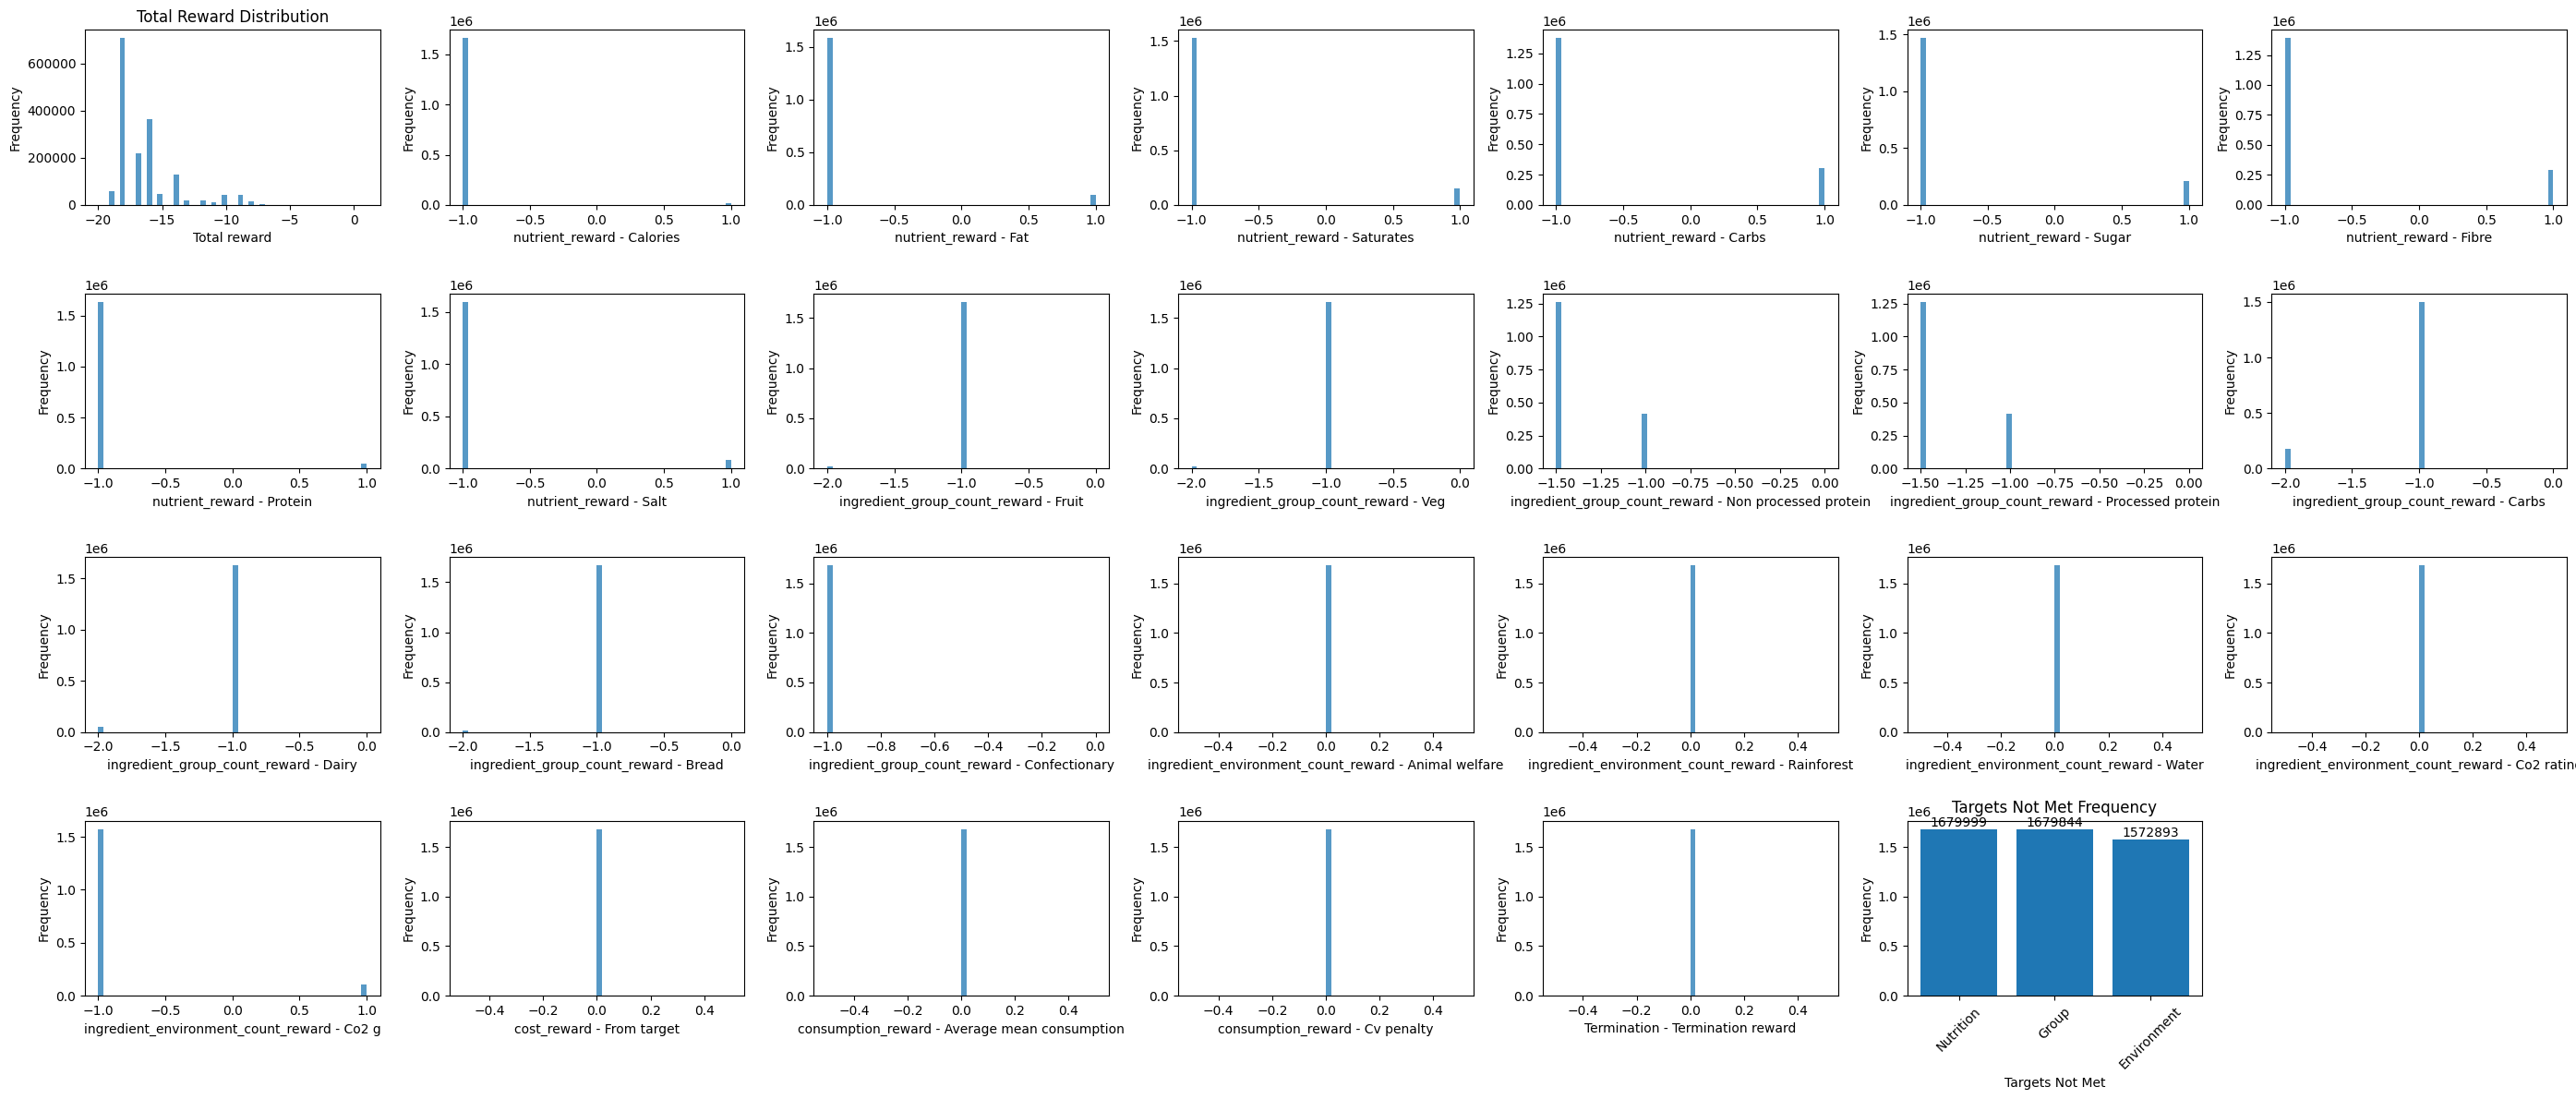

In [1]:
import time
import psutil
import threading
from utils.train_utils import *

def monitor_memory(stop_event, interval=1):
    """
    Function to monitor and print memory usage at regular intervals.
    """
    while not stop_event.is_set():
        mem = psutil.virtual_memory()
        print(f"Memory usage: {mem.percent}% used ({mem.used / (1024 ** 3):.2f} GB / {mem.total / (1024 ** 3):.2f} GB)")
        time.sleep(interval)

# Create an event to stop the thread
stop_event = threading.Event()

# Start memory monitoring in a separate thread
memory_thread = threading.Thread(target=monitor_memory, args=(stop_event,), daemon=True)
memory_thread.start()

# Load the reward distribution plot
load_path = "/home/laurie2905/Masters Thesis/Masters_RL/saved_models/reward/reward_test34_(7)"
plot_reward_distribution(load_path, save_plot_path=None, chunk_size=5000)

# Signal the memory monitoring thread to stop and wait for it to finish
stop_event.set()
memory_thread.join()

Memory usage: 41.9% used (2.90 GB / 7.64 GB)
Memory usage: 41.9% used (2.90 GB / 7.64 GB)
Memory usage: 41.9% used (2.90 GB / 7.64 GB)
Memory usage: 42.0% used (2.91 GB / 7.64 GB)
Memory usage: 42.3% used (2.94 GB / 7.64 GB)
Memory usage: 42.5% used (2.95 GB / 7.64 GB)
Memory usage: 42.8% used (2.97 GB / 7.64 GB)
Memory usage: 43.1% used (2.99 GB / 7.64 GB)
Memory usage: 43.5% used (3.02 GB / 7.64 GB)
Memory usage: 43.5% used (3.02 GB / 7.64 GB)
Memory usage: 43.6% used (3.03 GB / 7.64 GB)
Memory usage: 44.2% used (3.08 GB / 7.64 GB)
Memory usage: 44.7% used (3.11 GB / 7.64 GB)
Memory usage: 44.7% used (3.12 GB / 7.64 GB)
Memory usage: 45.1% used (3.15 GB / 7.64 GB)
Memory usage: 45.2% used (3.15 GB / 7.64 GB)
Memory usage: 45.4% used (3.17 GB / 7.64 GB)
Memory usage: 45.4% used (3.17 GB / 7.64 GB)
Memory usage: 46.0% used (3.21 GB / 7.64 GB)
Memory usage: 46.1% used (3.22 GB / 7.64 GB)
Memory usage: 46.8% used (3.28 GB / 7.64 GB)
Memory usage: 46.9% used (3.28 GB / 7.64 GB)
Memory usa

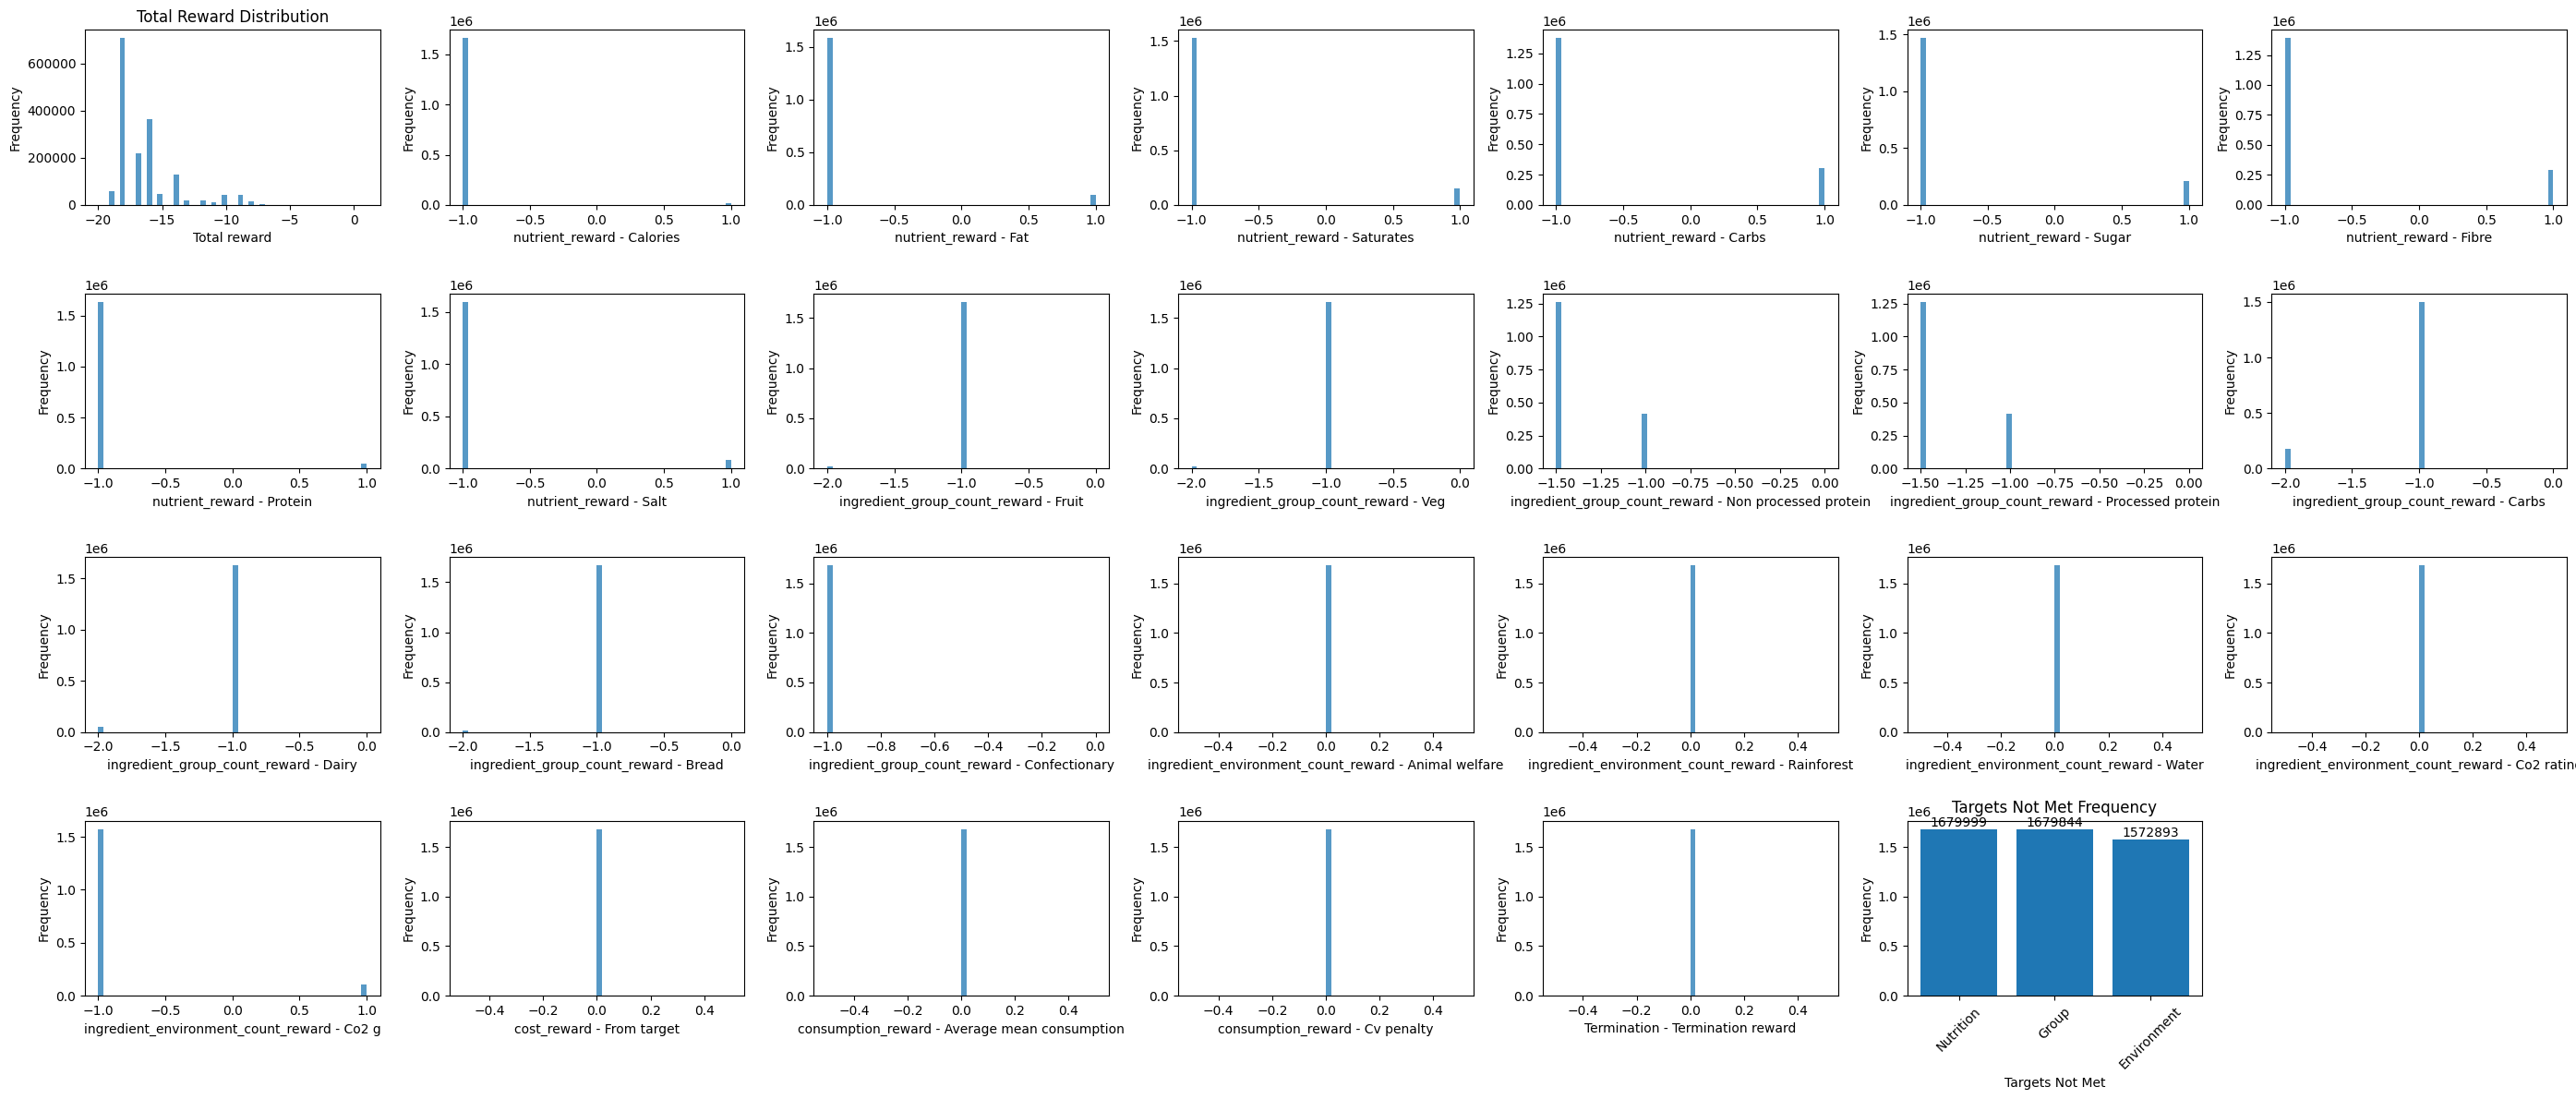

In [2]:
import time
import psutil
import threading
from utils.train_utils import *

def monitor_memory(stop_event, interval=1):
    """
    Function to monitor and print memory usage at regular intervals.
    """
    while not stop_event.is_set():
        mem = psutil.virtual_memory()
        print(f"Memory usage: {mem.percent}% used ({mem.used / (1024 ** 3):.2f} GB / {mem.total / (1024 ** 3):.2f} GB)")
        time.sleep(interval)

# Create an event to stop the thread
stop_event = threading.Event()

# Start memory monitoring in a separate thread
memory_thread = threading.Thread(target=monitor_memory, args=(stop_event,), daemon=True)
memory_thread.start()

# Load the reward distribution plot
load_path = "/home/laurie2905/Masters Thesis/Masters_RL/saved_models/reward/reward_test34_(7)"
plot_reward_distribution(load_path, save_plot_path=None, chunk_size=5000)

# Signal the memory monitoring thread to stop and wait for it to finish
stop_event.set()
memory_thread.join()

In [ ]:
from utils.process_data import get_data

# Load data
ingredient_df = get_data()

# Define the mapping dictionary
rating_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}

# Apply the mapping to the 'Animal Welfare Rating' column
x = [rating_to_int[val] for val in ingredient_df['Animal Welfare Rating'].values]

print(x)
print(x[0])
print(type(x))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Given values
mean = 7.59490565
standard_deviation = 11.22572649
threshold = 0  # Define the threshold below which people won't eat
value_in_meal_plan = 400
num_people = 1000  # Example number of people

# Generate random values from a normal distribution for each person
consumption_values = np.random.normal(loc=mean, scale=standard_deviation, size=num_people)

# Replace negative values with zero for realistic consumption values
consumption_values = np.where(consumption_values < 0, 0, consumption_values)

# Calculate the number of people not eating the ingredient
num_not_eating = np.sum(consumption_values == 0)

# Calculate the total expected consumption
total_expected_consumption = np.sum(consumption_values)

# Calculate the expected food waste
total_food_waste = value_in_meal_plan * num_people - total_expected_consumption

# Print results
print(f"Estimated number of people not eating the ingredient: {num_not_eating} out of {num_people}")
print(f"Total expected consumption: {total_expected_consumption:.2f} grams")
print(f"Total expected food waste for {num_people} people: {total_food_waste:.2f} grams")

# Optional: Print mean and standard deviation of the samples
print("Mean of the normal distribution samples:", np.mean(consumption_values))
print("Standard deviation of the normal distribution samples:", np.std(consumption_values))

# Visualize the distribution
plt.hist(consumption_values, bins=50, edgecolor='black')
plt.title('Distribution of Consumption Values')
plt.xlabel('Consumption Value (grams)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
from gymnasium.envs.registration import register
import gymnasium as gym

register(
    id='SchoolMealSelection-v1',
    entry_point='models.envs.env_working:SchoolMealSelection',
    max_episode_steps=10,  # Allow multiple steps per episode, adjust as needed
)

# Get the environment specification for 'SchoolMealSelection-v1'
env_spec = gym.envs.registry.get('SchoolMealSelection-v1')

if env_spec:
    print(f"\nEnvironment ID: {env_spec.id}")
    print(f"Entry Point: {env_spec.entry_point}")
    print(f"Max Episode Steps: {env_spec.max_episode_steps}")
else:
    print("Environment 'SchoolMealSelection-v1' is not registered.")


In [ ]:
max(1000 // 8, 1)

In [ ]:
ingredient_group_target_ranges = {
    'fruit': 1, # 1 fruit a day per meal
    'veg': 1, # 1 veg per day per meal
    'non_processed_protein': 1, # Portion of non processed protein has to be provided accept if a portion of processed protein is provided. This current env is one day meal selection.
    'processed_protein': 1, # Processed protein, see above ^
    'carbs': 1, # Starchy food , a portion of this should be provided every day
    'dairy': 1, # Dairy, a portion of this should be provided every day
    'bread': 1, # Bread should be provided as well as a portion of starchy food
    'confectionary': 0 # No confectionary should be provided
}
print(len(ingredient_group_target_ranges.keys()))
food_group_counts = {k: 0 for k in ingredient_group_target_ranges.keys()}

In [ ]:
import unittest

# Assuming the function and necessary variables are defined in a module named 'reward_module'
from models.reward.reward import group_count_reward

class TestGroupCountReward(unittest.TestCase):

    def setUp(self):
        # Setting up default values for the tests
        self.ingredient_group_portion = {
            'non_processed_protein': 300,
            'processed_protein': 200,
            'confectionary': 150,
            'vegetables': 500,
            'fruits': 300
        }
        
        self.ingredient_group_count = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }
        
        self.ingredient_group_portion_targets = {
            'non_processed_protein': (100, 150),
            'processed_protein': (80, 120),
            'confectionary': (50, 60),
            'vegetables': (80, 100),
            'fruits': (90, 110)
        }
        
        self.ingredient_group_count_targets = {
            'non_processed_protein': 3,
            'processed_protein': 2,
            'confectionary': 1,
            'vegetables': 5,
            'fruits': 3
        }

    def test_all_targets_met(self):
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertTrue(all_targets_met)
    
    def test_protein_target_not_met(self):
        self.ingredient_group_count['non_processed_protein'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_protein_target_exceeded(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -25,
            'processed_protein': -25,
            'confectionary': 100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_confectionary_target_not_met(self):
        self.ingredient_group_count['confectionary'] = 0
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': -100,
            'vegetables': 100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_not_met(self):
        self.ingredient_group_count['vegetables'] = 4
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': -100,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)
    
    def test_other_group_target_exceeded(self):
        self.ingredient_group_count['vegetables'] = 6
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': 50,
            'processed_protein': 50,
            'confectionary': 100,
            'vegetables': 0,
            'fruits': 100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

    def test_combination_of_targets(self):
        self.ingredient_group_count['non_processed_protein'] = 4
        self.ingredient_group_count['processed_protein'] = 3
        self.ingredient_group_count['confectionary'] = 2
        self.ingredient_group_count['vegetables'] = 4
        self.ingredient_group_count['fruits'] = 2
        
        ingredient_group_count_rewards = {group: 0 for group in self.ingredient_group_count}
        
        expected_rewards = {
            'non_processed_protein': -50,
            'processed_protein': -50,
            'confectionary': -100,
            'vegetables': -100,
            'fruits': -100
        }
        
        rewards, all_targets_met = group_count_reward(ingredient_group_count_rewards)
        
        self.assertEqual(rewards, expected_rewards)
        self.assertFalse(all_targets_met)

if __name__ == '__main__':
    unittest.main()


In [ ]:
def estimate_line_size(file_path, num_lines=100):
    with open(file_path, 'r') as file:
        total_size = 0
        for _ in range(num_lines):
            line = file.readline()
            total_size += len(line)
    return total_size / num_lines

In [ ]:
from utils.process_data import get_data
ingredient_df = get_data()

In [ ]:
print(ingredient_df.keys())

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Actor and Critic
class Actor(nn.Module):
    def __init__(self, state_dim, selection_action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, selection_action_dim)
        self.fc3 = nn.Linear(128, selection_action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        
        quantity = torch.relu(self.fc3(x))
        return quantity

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        value = self.fc2(x)
        return value

In [ ]:
import os
x = os.path.abspath("Masters_RL/saved_models/tensorboard/a2c_simple_calorie_env/")
print(os.path.exists(x))

In [ ]:
import gymnasium
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

class CustomEnv(gym.Env):
    def __init__(self, ingredient_df, num_people=1):
        super(CustomEnv, self).__init__()
        
        self.ingredient_df = ingredient_df
        self.num_people = num_people
        
        # Define action space
        n_ingredients = len(self.ingredient_df)
        
        self.action_space = spaces.Dict({
            'selection': spaces.MultiBinary(n_ingredients),
            'quantity': spaces.Box(low=0, high=100, shape=(n_ingredients,), dtype=np.float32)
        })
        
        # State includes quantities of ingredients and average calories
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(n_ingredients + 1,), dtype=np.float32)
        
        # self.state = None

    # def reset(self):
    #     n_ingredients = len(self.ingredient_df)
    #     self.state = np.zeros(n_ingredients + 1, dtype=np.float32)  # Reset state to zeros including average calories
    #     return self.state

    def calculate_reward(self, action):
        reward = 0.0
        
        # Convert action selection and quantity to numpy arrays
        selection = np.array(action['selection'], dtype=np.float32)
        quantity = np.array(action['quantity'], dtype=np.float32)
        
        # Reward based on the number of selected ingredients
        total_selection = np.sum(selection)
        
        if total_selection > 10:
            reward -= 10
        elif total_selection < 5:
            reward -= 10
        else:
            reward += 10
        
        # Calculate calories for selected ingredients
        calories_per_100g = self.ingredient_df['Calories_kcal_per_100g'].values
        calories_selected_ingredients = selection * quantity * calories_per_100g / 100
        
        # Calculate average calories per day per person
        average_calories_per_day = np.sum(calories_selected_ingredients) / self.num_people
        
        # Reward based on the average calories per day
        if 2000 <= average_calories_per_day <= 3000:
            reward += 100
            done = True
        else:
            reward -= 10
            done = False
        
        return reward, average_calories_per_day, done

    def step(self, action):
        n_ingredients = len(self.ingredient_df)
        
        # Update the state based on action
        self.state[:n_ingredients] = action['quantity']  # Update state with quantities of selected ingredients
        
        # Calculate reward
        reward, average_calories_per_day, done = self.calculate_reward(action)
        
        # Update the state with average calories
        self.state[-1] = average_calories_per_day
        
        info = {
            'average_calories_per_day': average_calories_per_day
        }

        return self.state, reward, done, info

def train_actor_critic(env, actor, critic, num_episodes=1000, gamma=0.99, actor_lr=1e-4, critic_lr=1e-3, device='cuda'):
    # Move models to the GPU
    actor.to(device)
    critic.to(device)
    
    actor_optimizer = optim.Adam(actor.parameters(), lr=actor_lr)
    critic_optimizer = optim.Adam(critic.parameters(), lr=critic_lr)
    mse_loss = nn.MSELoss()

    for episode in range(num_episodes):
        state = env.reset()
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        done = False
        total_reward = 0
        episode_info = None

        while not done:
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().cpu().numpy().squeeze(),
                'quantity': quantity.detach().cpu().numpy().squeeze()
            }
            next_state, reward, done, info = env.step(action)
            next_state = torch.FloatTensor(next_state).unsqueeze(0).to(device)
            reward = torch.tensor([reward], dtype=torch.float32).to(device)

            # Save the info for the end of the episode
            episode_info = info

            # Update Critic
            value = critic(state)
            next_value = critic(next_state)
            target = reward + (1 - done) * gamma * next_value
            critic_loss = mse_loss(value, target.detach())
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step()

            # Update Actor
            advantage = (target - value).detach()
            actor_loss = -advantage * (selection_probs.mean() + quantity.mean())
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step()

            state = next_state
            total_reward += reward

            # Debug prints
            print(f"Reward: {reward.item()}, Done: {done}")

        if episode_info is not None and 'average_calories_per_day' in episode_info:
            average_calories_per_day = episode_info['average_calories_per_day']
        else:
            average_calories_per_day = float('nan')

        print(f"Episode: {episode+1}, Total Reward: {total_reward.item()}, Average Calories per Day: {average_calories_per_day}")


In [ ]:
# Create environment and models
env = CustomEnv(ingredient_df)

state_dim = env.state.shape[0]
selection_action_dim = env.action_space['selection'].n
actor = Actor(state_dim, selection_action_dim)
critic = Critic(state_dim)


# Train the model
train_actor_critic(env, actor, critic, num_episodes=5)

# Evaluate the model
# evaluate_actor(env, actor, num_days=5)

In [ ]:
# Evaluation function
def evaluate_actor(env, actor, num_days=5):
    state = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0)
    done = False
    total_reward = 0
    episode_selections = []

    while not done:
        with torch.no_grad():
            selection_probs, quantity = actor(state)
            selection = (selection_probs > 0.5).float()  # Binarize selection actions
            action = {
                'selection': selection.detach().numpy().squeeze(),
                'quantity': quantity.detach().numpy().squeeze()
            }
        next_state, reward, done, info = env.step(action)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        episode_selections.append(action)

        state = next_state
        total_reward += reward

    print(f"Evaluation Total Reward: {total_reward}")
    for day, selections in enumerate(env.selections, 1):
        print(f"Day {day}:")
        for i, (selection, quantity) in enumerate(selections):
            print(f"  Try {i+1}: Selection - {selection}, Quantity - {quantity}")

